# Предсказание цен криптовалют

### Этап 1: Разведочный анализ данных (EDA)

#### Подключение библиотек

In [ ]:
!pip install scikeras

In [ ]:
# Стандартные библиотеки Python
import warnings  # Управление предупреждениями в коде
import random    # Генерация случайных чисел
import json

# Библиотеки для работы с данными
import pandas as pd  # Работа с табличными данными
import numpy  as np  # Научные вычисления

# Библиотеки для машинного обучения
from sklearn.preprocessing   import MinMaxScaler                          # Масштабирование данных
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit   # Поиск по сетке параметров
from sklearn.base            import BaseEstimator, RegressorMixin         # Базовые классы для создания пользовательских оценщиков

# Библиотеки для глубокого обучения
from keras.models                import Sequential       # Базовый класс для создания нейронных сетей
from keras.layers                import LSTM, Dense      # Слои LSTM и полносвязный
from tensorflow.keras.optimizers import Adam             # Оптимизатор Adam
from tensorflow.keras.callbacks  import EarlyStopping    # Ранняя остановка обучения
from scikeras.wrappers           import KerasRegressor   # Обертка для интеграции Keras с scikit-learn

import pickle
from keras.models import load_model  # Используем keras.models.load_model для сохранения модели весов

# Библиотеки для визуализации
import matplotlib.pyplot as plt    # Визуализация данных
import plotly.graph_objects as go  # Интерактивная визуализация

# Дополнительные утилиты
from functools import partial  # Функция для частичного применения функций

# Инициализация генератора случайных чисел
random_state = random.seed(42)

In [ ]:
class CustomKerasRegressor(BaseEstimator, RegressorMixin):
    """
    Класс CustomKerasRegressor для реализации регрессии на основе Keras модели с использованием LSTM слоев.

    Параметры:
    ----------
    optimizer : str, опционально
        Оптимизатор для компиляции Keras модели (по умолчанию 'adam').
    units : int, опционально
        Количество нейронов в LSTM слоях (по умолчанию 50).
    epochs : int, опционально
        Количество эпох для обучения (по умолчанию 10).
    batch_size : int, опционально
        Размер батча для обучения (по умолчанию 32).
    activation : str, опционально
        Функция активации для LSTM слоев (по умолчанию 'tanh').
    """
    def __init__(self, batch_size=32, epochs=10, optimizer='adam', units=50, lstm_layers=[50], activation='tanh', input_dim=None, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.units = units
        self.lstm_layers = lstm_layers
        self.activation = activation
        self.input_dim = input_dim

    def __getstate__(self):

        # Возвращаем атрибуты, которые нужно сериализовать
        state = self.__dict__.copy()
        state['model_'] = None  # Заменяем модель на None, чтобы не пытаться сериализовать Keras модель
        return state

    def __setstate__(self, state):

        # Восстанавливаем атрибуты из состояния
        self.__dict__.update(state)

    def build_model(self, input_shape):
        """
        Метод для создания и компиляции Keras модели.

        Параметры:
        ----------
        input_shape : tuple
            Размерность входных данных.

        Возвращает:
        ----------
        model : Keras модель
            Скомпилированная Keras модель.
        """
        model = Sequential()

        # Добавляем первый LSTM слой с указанием размерности входных данных
        model.add(LSTM(units=self.lstm_layers[0], activation=self.activation, return_sequences=True if len(self.lstm_layers) > 1 else False, input_shape=input_shape))

        # Цикл для добавления оставшихся LSTM слоев
        for i, units in enumerate(self.lstm_layers[1:]):
            model.add(LSTM(units=units, activation=self.activation, return_sequences=True if i < len(self.lstm_layers) - 2 else False))

        model.add(Dense(units=25, activation=self.activation))
        model.add(Dense(units=1))
        model.compile(optimizer=self.optimizer, loss='mean_squared_error')  # В качестве метрики используется среднеквадратическая ошибка

        return model

    def fit(self, X, y, **kwargs):
        """
        Метод для обучения модели.

        Параметры:
        ----------
        X : array-like
            Массив признаков.
        y : array-like
            Массив меток.

        Возвращает:
        ----------
        self : объект
            Текущий экземпляр класса.
        """
        input_shape = (X.shape[1], 1)
        self.model_ = self.build_model(input_shape)
        wrapper = KerasRegressor(build_fn=lambda: self.model_, epochs=self.epochs, batch_size=self.batch_size)
        wrapper.fit(X, y, **kwargs)
        return self

    def predict(self, X):
        """
        Метод для предсказания.

        Параметры:
        ----------
        X : array-like
            Массив признаков.

        Возвращает:
        ----------
        array-like
            Массив предсказаний.
        """
        return self.model_.predict(X)

    def save_model(self, path):
        """
        Метод для сохранения весов Keras модели в файл.

        Параметры:
        ----------
        path : str
            Путь к файлу, в котором будут сохранены веса модели.
        """
        # Сохраняем веса модели, чтобы можно было восстановить её структуру при десериализации
        self.model_.save_weights(path)

    def load_model(self, path):
        """
        Метод для создания нового экземпляра Keras модели и загрузки весов из файла.

        Параметры:
        ----------
        path : str
            Путь к файлу, из которого будут загружены веса модели.

        Возвращает:
        ----------
        self : object
            Текущий экземпляр класса с загруженными весами модели.
        """
        input_shape = (self.input_dim, 1)  # Указываем размерность входных данных
        self.model_ = self.build_model(input_shape)
        self.model_.load_weights(path)
        return self

    def set_parameters(self, batch_size=32, epochs=10, optimizer='adam', units=50, lstm_layers=[50], activation='tanh'):
        """
        Метод для установки параметров модели CustomKerasRegressor при загрузки модели из h5.

        Параметры:
        ----------
        batch_size : int, опционально
            Размер батча для обучения модели (по умолчанию 32).
        epochs : int, опционально
            Количество эпох для обучения модели (по умолчанию 10).
        optimizer : str, опционально
            Оптимизатор для компиляции модели (по умолчанию 'adam').
        units : int, опционально
            Количество нейронов в LSTM слоях модели (по умолчанию 50).
        lstm_layers : list, опционально
            Список, определяющий структуру LSTM слоев (по умолчанию [50]).
        activation : str, опционально
            Функция активации для LSTM слоев (по умолчанию 'tanh').

        Возвращает:
        ----------
        None
        """
        self.batch_size = batch_size
        self.epochs = epochs
        self.optimizer = optimizer
        self.units = units
        self.lstm_layers = lstm_layers
        self.activation = activation

def preprocess_dataframe(df: pd.DataFrame):
    """
    Предобработка датафрейма: переименование столбцов, преобработка дат и преобразование числовых значений.

    Параметры:
        df (pd.DataFrame): Исходный датафрейм, который необходимо предобработать.

    Возвращает:
        pd.DataFrame: Предобработанный датафрейм.

    Пример использования:
        processed_df = preprocess_dataframe(raw_df)
    """

    # Словарь для переименования столбцов
    column_mapping = {
        "Дата\xa0": "Date",
        "Открытия\xa0": "Open",
        "Макс.\xa0": "High",
        "Мин.\xa0": "Low",
        "Закрытия\xa0": "Close",
        "Объём\xa0": "Volume",
        "Рыночная Капитализация\xa0": "Market_Capitalization"
    }
    df.rename(columns=column_mapping, inplace=True)

    # Словарь для перевода русских названий месяцев в английские
    month_translation = {
        'янв': 'Jan',
        'фев': 'Feb',
        'мар': 'Mar',
        'апр': 'Apr',
        'май': 'May',
        'июн': 'Jun',
        'июл': 'Jul',
        'авг': 'Aug',
        'сен': 'Sep',
        'окт': 'Oct',
        'ноя': 'Nov',
        'дек': 'Dec'
    }

    # Преобразование названий месяцев
    for rus, eng in month_translation.items():
        df['Date'] = df['Date'].str.replace(rus, eng)

    # Преобразование столбца "Date" в datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y')

    # Преобразование остальных столбцов в числовой формат
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Market_Capitalization']
    for col in numeric_columns:
        # Удаление символов доллара и запятых
        df[col] = df[col].str.replace('$', '').str.replace(',', '')
        # Преобразование в числовой формат (float)
        df[col] = df[col].astype(float)

def prepare_data(df: pd.DataFrame) -> tuple:
    """
    Функция для подготовки данных для LSTM.

    Алгоритм:
    1. Сортирует DataFrame по дате в порядке убывания.
    2. Отделяет значения "Close" и нормализует их.
    3. Создает обучающую и тестовую выборки.

    Параметры:
    - df: DataFrame с историческими данными акций, содержащий колонки 'Date' и 'Close'.

    Возвращает:
    - X_train, y_train: обучающая выборка.
    - X_test, y_test: тестовая выборка.
    """

    # Преобразуем данные в тип 'дата'
    df['Date'] = pd.to_datetime(df['Date'])

    # Сначала отсортируем DataFrame по колонке Date от меньшего к большему
    df = df.sort_values('Date', ascending=True)
    df.set_index('Date', inplace=True)

    # Отделите Close значение для обучения
    dataset = df['Close'].values
    dataset = dataset.reshape(-1, 1)

    # Нормализация данных
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)

    # Отделяем тестовую выборку (последние 90 строк)
    test_data = scaled_data[-90:]
    train_data = scaled_data[:-90]

    X_train = []
    y_train = []

    for i in range(60, len(train_data)):
        X_train.append(train_data[i-60:i, 0])
        y_train.append(train_data[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    X_test = []
    y_test = dataset[:90]
    for i in range(60, len(test_data)):
        X_test.append(test_data[i-60:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test, scaler

def find_best_model(X_train, y_train, n_splits=5, n_iter=10):
    """
    Функция для поиска лучшей Keras модели с использованием RandomizedSearchCV и TimeSeriesSplit.

    Параметры:
    ----------
    X_train : array-like
        Обучающий набор данных (признаки).
    y_train : array-like
        Обучающий набор данных (метки).
    n_splits : int
        Количество разбиений для TimeSeriesSplit.
    n_iter : int
        Количество итераций для RandomizedSearchCV.

    Возвращает:
    ----------
    best_model : object
        Лучшая обученная модель.
    """

    # Параметры для RandomizedSearchCV
    param_distributions = {
        'epochs': [5],
        'batch_size': [1],
        'optimizer': ['adam', 'rmsprop', 'sgd', 'adagrad'],
        'activation': ['tanh', 'relu', 'sigmoid', 'softmax'],
        'units': [50],
        'lstm_layers': [[6]]}

    # Инициализация модели
    model = CustomKerasRegressor()

    # Параметры кросс-валидации
    tscv = TimeSeriesSplit(n_splits=n_splits)

    # Поиск по сетке параметров
    random_search = RandomizedSearchCV(estimator=model, param_distributions=param_distributions,
                                       n_iter=n_iter, cv=tscv, n_jobs=-1, random_state=42)

    random_search_result = random_search.fit(X_train, y_train)

    # Вывод лучших параметров и MSE
    print("Лучшие параметры: {}".format(random_search_result.best_params_))
    print("Лучшее значение MSE: {}".format(-random_search_result.best_score_))

    # Возврат лучшей модели
    return random_search_result.best_estimator_, random_search_result.best_params_, -random_search_result.best_score_

def learning_pipeline(name, X_train, y_train, n_range=1):
    """
    Обучает N моделей на тренировочных данных и сохраняет лучшую модель.

    Параметры:
    -----------
    name : str
        Имя, под которым будет сохранена лучшая модель.
    X_train : array-like
        Массив признаков для тренировочных данных.
    y_train : array-like
        Массив целевых переменных для тренировочных данных.
    n_range : int, optional (по умолчанию = 1)
        Количество моделей для обучения и сравнения.

    Возвращаемые значения:
    ---------------------
    None
        Функция не возвращает значения, но сохраняет лучшую модель на диск и выводит информацию о ней.
    """

    # Инициализация переменных
    best_mse = float('inf')
    best_model = None
    best_params = None

    # Обучаем N моделей и ищем лучшую
    for i in range(n_range):
        model, params, mse = find_best_model(X_train, y_train)

        if mse < best_mse:
            best_mse = mse
            best_model = model
            best_params = params

    # Сохраняем модель
    best_model.save_model(f'/content/drive/MyDrive/model/model_{name}.h5')

    # Сохраняем параметры лучшей модели в JSON-формате
    with open(f'/content/drive/MyDrive/model/model_{name}_params.txt', 'w') as f:
        json.dump(best_params, f)

    # Выводим параметры лучшей модели
    print('-------------------------------------------------------------------')
    print(f'Best Model: {best_model}')
    print(f'Best Parameters: {best_params}')
    print(f'Best MSE: {best_mse}')
    print('-------------------------------------------------------------------')

def plot_interactive_time_series_predictions(df, predictions, title='Stock Price Prediction', xlabel='Date', ylabel='Stock Price USD ($)'):
    """
    Визуализация предсказаний временного ряда с использованием интерактивного графика Plotly.

    Параметры:
        df (pd.DataFrame): Исходный датафрейм со всеми данными.
        predictions (np.array): Массив с предсказанными значениями.
        title (str): Заголовок графика. По умолчанию 'Stock Price Prediction'.
        xlabel (str): Название оси X. По умолчанию 'Date'.
        ylabel (str): Название оси Y. По умолчанию 'Stock Price USD ($)'.
    """

    valid = df.tail(len(predictions)).copy()  # берем последние значения, соответствующие длине предсказаний
    valid['Predictions'] = predictions

    # Создаем интерактивный график
    fig = go.Figure()

    # Добавляем линии: настоящие значения и предсказанные
    fig.add_trace(go.Scatter(x=valid.index, y=valid['Close'], mode='lines', name='Actual Value'))
    fig.add_trace(go.Scatter(x=valid.index, y=valid['Predictions'], mode='lines', name='Predictions'))

    # Устанавливаем заголовок графика и подписи осей
    fig.update_layout(title=title, xaxis_title=xlabel, yaxis_title=ylabel)

    fig.show()

def predict_and_plot(model, last_60_days_data, scaler, future_days=30):
    """
    Прогнозирует и визуализирует цену актива на заданное количество дней вперед, используя LSTM модель.

    Параметры:
    - model (Keras Model): Обученная LSTM модель для прогнозирования.
    - last_60_days_data (ndarray): Массив данных за последние 60 дней, который будет использован для начального прогнозирования.
    - scaler (MinMaxScaler): Объект для масштабирования данных.
    - future_days (int, опционально): Количество дней для прогноза. По умолчанию равно 30.

    Вывод:
    Функция создает график, показывающий прогнозируемые значения на заданное количество дней вперед.
    """
    # Инициализация списка для хранения прогнозов
    predictions = []

    # Данные для начального прогноза (последние 60 дней из тестового набора)
    last_60_days = np.array(last_60_days_data)

    # Процесс прогнозирования
    for i in range(future_days):
        # Прогнозирование следующего дня на основе последних 60 дней
        pred = model.predict(last_60_days.reshape(1, -1, 1))

        # Добавление прогноза в список
        predictions.append(pred[0][0])

        # Обновление last_60_days с учетом нового прогноза
        last_60_days = np.roll(last_60_days, -1)
        last_60_days[-1] = pred

    # Обратное масштабирование прогнозов
    predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

    # Визуализация прогноза
    plt.plot(range(future_days), predictions)
    plt.title('Solana Price Prediction for Next 30 Days')
    plt.xlabel('Days')
    plt.ylabel('Price')
    plt.show()

---
# Solana
#### Загрузка данных из файла

In [ ]:
Solana = pd.read_excel('/content/Solana.xlsx')
Solana.head()

,Дата,Открытия,Макс.,Мин.,Закрытия,Объём,Рыночная Капитализация
0,"окт 25, 2023",$31.82,$32.30,$28.97,$30.26,"$1,328,792,708","$12,645,365,708"
1,"окт 24, 2023",$29.00,$32.17,$28.84,$31.64,"$1,365,540,076","$13,189,526,723"
2,"окт 23, 2023",$29.35,$29.88,$28.28,$28.98,"$606,434,466","$12,077,732,760"
3,"окт 22, 2023",$27.03,$29.99,$26.71,$29.37,"$1,029,645,602","$12,239,000,223"
4,"окт 21, 2023",$24.95,$27.26,$24.84,$27.05,"$825,548,645","$11,267,911,275"


#### Первичный осмотр и предобработка данных

In [ ]:
preprocess_dataframe(Solana)
Solana.head()

<ipython-input-55-cc0d4647b464>:221: FutureWarning:

The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.



,Date,Open,High,Low,Close,Volume,Market_Capitalization
0,2023-10-25,31.82,32.30,28.97,30.26,1.328793e+09,1.264537e+10
1,2023-10-24,29.00,32.17,28.84,31.64,1.365540e+09,1.318953e+10
2,2023-10-23,29.35,29.88,28.28,28.98,6.064345e+08,1.207773e+10
3,2023-10-22,27.03,29.99,26.71,29.37,1.029646e+09,1.223900e+10
4,2023-10-21,24.95,27.26,24.84,27.05,8.255486e+08,1.126791e+10


---
### Этап 2: Подготовим данные к обучению

In [ ]:
X_train_Solana, y_train_Solana, X_test_Solana, y_test_Solana, scaler = prepare_data(Solana)

### Этап 3: Обучение модели

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
learning_pipeline('Solana', X_train_Solana, y_train_Solana, n_range=10)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 4s 11ms/step - loss: 0.0166
Epoch 2/5
148/148 [==============================] - 2s 15ms/step - loss: 0.0058
Epoch 3/5
148/148 [==============================] - 3s 19ms/step - loss: 0.0047
Epoch 4/5
148/148 [==============================] - 2s 14ms/step - loss: 0.0042
Epoch 5/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0038
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.3874859911935981


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 4s 16ms/step - loss: 0.0229
Epoch 2/5
148/148 [==============================] - 3s 19ms/step - loss: 0.0098
Epoch 3/5
148/148 [==============================] - 2s 13ms/step - loss: 0.0077
Epoch 4/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0062
Epoch 5/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0051
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.3716824384037921


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 4s 11ms/step - loss: 0.0113
Epoch 2/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0054
Epoch 3/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0048
Epoch 4/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0042
Epoch 5/5
148/148 [==============================] - 3s 18ms/step - loss: 0.0039
Лучшие параметры: {'units': 50, 'optimizer': 'adam', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.24037773658952513


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 4s 11ms/step - loss: 0.0404
Epoch 2/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0079
Epoch 3/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0054
Epoch 4/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0046
Epoch 5/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0040
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.6156997298421153


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 4s 12ms/step - loss: 0.0261
Epoch 2/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0076
Epoch 3/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0054
Epoch 4/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0044
Epoch 5/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0039
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.8371949323435952


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 3s 11ms/step - loss: 0.0271
Epoch 2/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0077
Epoch 3/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0060
Epoch 4/5
148/148 [==============================] - 3s 17ms/step - loss: 0.0047
Epoch 5/5
148/148 [==============================] - 3s 18ms/step - loss: 0.0040
Лучшие параметры: {'units': 50, 'optimizer': 'adam', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.6973872669522453


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 3s 14ms/step - loss: 0.0867
Epoch 2/5
148/148 [==============================] - 3s 19ms/step - loss: 0.0061
Epoch 3/5
148/148 [==============================] - 2s 15ms/step - loss: 0.0047
Epoch 4/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0043
Epoch 5/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0039
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'relu'}
Лучшее значение MSE: 0.22503281576021514


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 5s 17ms/step - loss: 0.0368
Epoch 2/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0065
Epoch 3/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0050
Epoch 4/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0041
Epoch 5/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0036
Лучшие параметры: {'units': 50, 'optimizer': 'adam', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.4580892881730839


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 4s 12ms/step - loss: 0.0715
Epoch 2/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0093
Epoch 3/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0076
Epoch 4/5
148/148 [==============================] - 2s 12ms/step - loss: 0.0057
Epoch 5/5
148/148 [==============================] - 3s 17ms/step - loss: 0.0054
Лучшие параметры: {'units': 50, 'optimizer': 'adam', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 1.054109496513658


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning:

``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.



148/148 [==============================] - 3s 11ms/step - loss: 0.0442
Epoch 2/5
148/148 [==============================] - 2s 11ms/step - loss: 0.0099
Epoch 3/5
148/148 [==============================] - 2s 17ms/step - loss: 0.0072
Epoch 4/5
148/148 [==============================] - 3s 19ms/step - loss: 0.0053
Epoch 5/5
148/148 [==============================] - 2s 13ms/step - loss: 0.0045
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.27011282400296144
-------------------------------------------------------------------
Best Model: CustomKerasRegressor(activation='relu', batch_size=1, epochs=5, lstm_layers=[6],
                     optimizer='rmsprop')
Best Parameters: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'relu'}
Best MSE: 0.22503281576021514
-------------------------------------------------------------------


### Загрузка модели

In [ ]:
loaded_model = CustomKerasRegressor()
loaded_model.set_parameters(units=50, optimizer='rmsprop', lstm_layers=[6], epochs=5, batch_size=1, activation='relu')
model_Solana = loaded_model.load_model('/content/drive/MyDrive/model/model_Solana.h5')

---
### Этап 4: Отобразим результаты на графике

In [ ]:
predictions_Solana = model_Solana.predict(X_test_Solana)
predictions_Solana = scaler.inverse_transform(predictions_Solana)  # Дескалирование предсказаний обратно к исходным значениям

df = Solana.sort_values('Date', ascending=True)
df.set_index('Date', inplace=True)

plot_interactive_time_series_predictions(df, predictions_Solana)

1/1 [==============================] - 0s 318ms/step


1/1 [==============================] - 0s 23ms/step


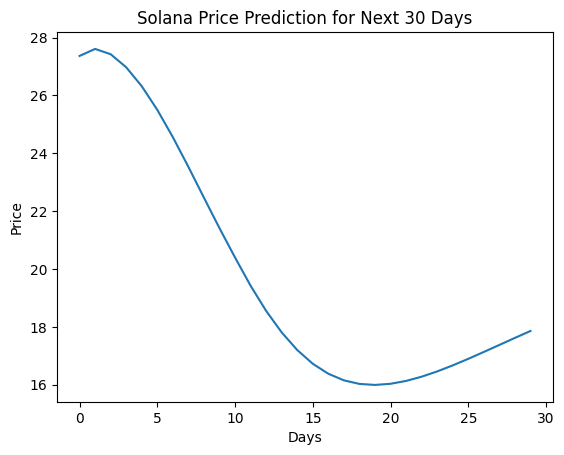

In [ ]:
predict_and_plot(model_Solana, X_test_Solana[-1], scaler)

---
# Toncoin

In [ ]:
Toncoin = pd.read_excel('/content/Toncoin.xlsx')
Toncoin.head()

,Дата,Открытия,Макс.,Мин.,Закрытия,Объём,Рыночная Капитализация
0,"окт 27, 2023",$2.12,$2.13,$2.03,$2.06,"$17,044,760","$7,062,114,772"
1,"окт 26, 2023",$2.14,$2.18,$2.08,$2.12,"$43,667,080","$7,291,307,011"
2,"окт 25, 2023",$2.13,$2.15,$2.12,$2.14,"$41,637,235","$7,331,075,043"
3,"окт 24, 2023",$2.17,$2.25,$2.12,$2.13,"$52,853,464","$7,308,082,010"
4,"окт 23, 2023",$2.19,$2.22,$2.13,$2.17,"$48,873,140","$7,458,105,432"


In [ ]:
preprocess_dataframe(Toncoin)
Toncoin.head()

<ipython-input-5-36a048c51896>:221: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df[col] = df[col].str.replace('$', '').str.replace(',', '')


,Date,Open,High,Low,Close,Volume,Market_Capitalization
0,2023-10-27,2.12,2.13,2.03,2.06,17044760.0,7.062115e+09
1,2023-10-26,2.14,2.18,2.08,2.12,43667080.0,7.291307e+09
2,2023-10-25,2.13,2.15,2.12,2.14,41637235.0,7.331075e+09
3,2023-10-24,2.17,2.25,2.12,2.13,52853464.0,7.308082e+09
4,2023-10-23,2.19,2.22,2.13,2.17,48873140.0,7.458105e+09


In [ ]:
X_train_Toncoin, y_train_Toncoin, X_test_Toncoin, y_test_Toncoin, scaler = prepare_data(Toncoin)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
learning_pipeline('Toncoin', X_train_Toncoin, y_train_Toncoin, n_range=10)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 4s 11ms/step - loss: 0.0197
Epoch 2/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0039
Epoch 3/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0036
Epoch 4/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0036
Epoch 5/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0035
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.9374809476789299


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 3s 12ms/step - loss: 0.0462
Epoch 2/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0064
Epoch 3/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0045
Epoch 4/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0041
Epoch 5/5
147/147 [==============================] - 3s 19ms/step - loss: 0.0034
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 1.1419070421208573


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 4s 16ms/step - loss: 0.1382
Epoch 2/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0118
Epoch 3/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0055
Epoch 4/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0045
Epoch 5/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0049
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'relu'}
Лучшее значение MSE: 1.5622369871315185


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 4s 12ms/step - loss: 0.1014
Epoch 2/5
147/147 [==============================] - 3s 18ms/step - loss: 0.0096
Epoch 3/5
147/147 [==============================] - 3s 18ms/step - loss: 0.0040
Epoch 4/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0035
Epoch 5/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0033
Лучшие параметры: {'units': 50, 'optimizer': 'adam', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.8335844635615901


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 3s 11ms/step - loss: 0.1295
Epoch 2/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0188
Epoch 3/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0048
Epoch 4/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0042
Epoch 5/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0037
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'relu'}
Лучшее значение MSE: 0.6414566196595436


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 4s 12ms/step - loss: 0.0415
Epoch 2/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0060
Epoch 3/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0042
Epoch 4/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0036
Epoch 5/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0037
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 1.2029312624285284


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 3s 12ms/step - loss: 0.0552
Epoch 2/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0047
Epoch 3/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0033
Epoch 4/5
147/147 [==============================] - 2s 11ms/step - loss: 0.0031
Epoch 5/5
147/147 [==============================] - 2s 16ms/step - loss: 0.0033
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.6915027603187286


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 4s 13ms/step - loss: 0.0462
Epoch 2/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0031
Epoch 3/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0029
Epoch 4/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0028
Epoch 5/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0027
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.22404163130879046


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 5s 19ms/step - loss: 0.0942
Epoch 2/5
147/147 [==============================] - 2s 15ms/step - loss: 0.0064
Epoch 3/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0035
Epoch 4/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0034
Epoch 5/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0031
Лучшие параметры: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 1.5991785014733244


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


147/147 [==============================] - 4s 12ms/step - loss: 0.1018
Epoch 2/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0100
Epoch 3/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0046
Epoch 4/5
147/147 [==============================] - 2s 12ms/step - loss: 0.0040
Epoch 5/5
147/147 [==============================] - 2s 13ms/step - loss: 0.0041
Лучшие параметры: {'units': 50, 'optimizer': 'adam', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Лучшее значение MSE: 0.7140450398381919
-------------------------------------------------------------------
Best Model: CustomKerasRegressor(batch_size=1, epochs=5, lstm_layers=[6],
                     optimizer='rmsprop')
Best Parameters: {'units': 50, 'optimizer': 'rmsprop', 'lstm_layers': [6], 'epochs': 5, 'batch_size': 1, 'activation': 'tanh'}
Best MSE: 0.22404163130879046
-------------------------------------------------------------------


In [ ]:
loaded_model = CustomKerasRegressor()
loaded_model.set_parameters(units=50, optimizer='rmsprop', lstm_layers=[6], epochs=5, batch_size=1, activation='tanh')
model_Toncoin = loaded_model.load_model('/content/drive/MyDrive/model/model_Toncoin.h5')

In [ ]:
predictions_Toncoin = model_Toncoin.predict(X_test_Toncoin)
predictions_Toncoin = scaler.inverse_transform(predictions_Toncoin)  # Дескалирование предсказаний обратно к исходным значениям

df = Toncoin.sort_values('Date', ascending=True)
df.set_index('Date', inplace=True)

plot_interactive_time_series_predictions(df, predictions_Toncoin)

1/1 [==============================] - 1s 667ms/step


1/1 [==============================] - 0s 40ms/step


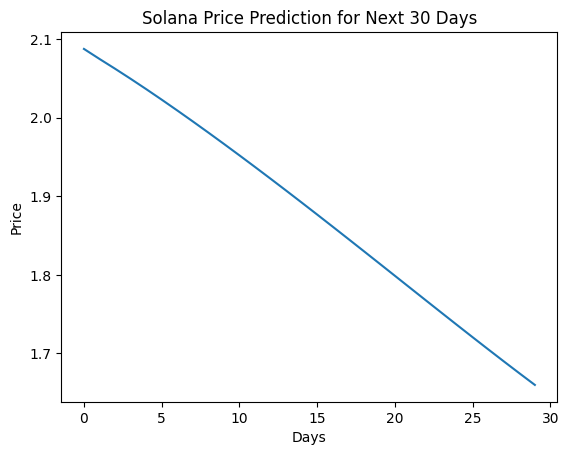

In [ ]:
predict_and_plot(model_Toncoin, X_test_Toncoin[-1], scaler)

test